In [36]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trainset = pd.read_csv("../Downloads/Predict_churn/train.csv")

In [3]:
members = pd.read_csv("../Downloads/Predict_churn/members.csv")

In [42]:
#members_train = pd.concat([trainset,members], keys=['msno'], axis=1, join= "inner")
members_train = pd.merge(trainset, members, how='inner', on="msno")

In [43]:
members_train[:5]

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,expiration_date
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,female,9,20050406,20170907
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,male,9,20050407,20170321
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,female,9,20051016,20170203
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,female,9,20051102,20170926
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27,male,9,20051228,20170927


In [44]:
colnames = ["city", "bd", "gender", "registered_via", "registration_init_time", "expiration_date"]
X_train = members_train[colnames]

In [45]:
Y_train = members_train["is_churn"]

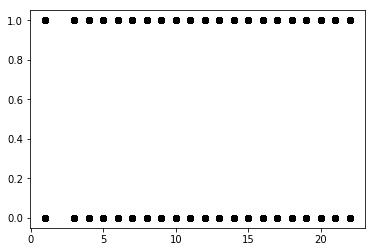

In [46]:
plt.plot(X_train["city"], Y_train, 'o', color='black')

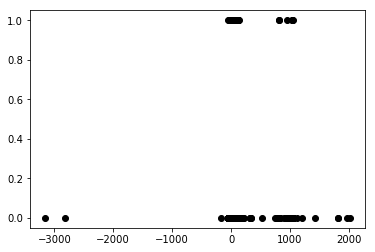

In [47]:
plt.plot(X_train["bd"], Y_train, 'o', color='black')

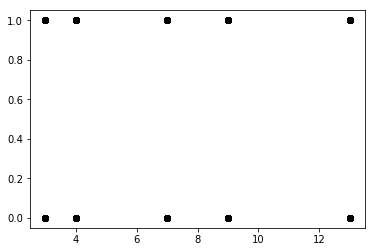

In [40]:
plt.plot(X_train["registered_via"], Y_train, 'o', color='black')

In [ ]:
registration_init_time